# Speed Dating - Gonna Get the Match?

Dating is hard for anyone, and it can be really rough when you get your hopes up about someone who ultimately doesn't feel the same way.  So, being nerdy data scientists, of course we want an algorithm to predict if we'll match with someone at a speed dating event so we don't have to actually go speed dating.  

First, we need to import everything we're going to need, including the data we have aquired about speed dating pairs.  The data includes the responses from the participants from a series of questionaires, and currently has nearly two hundred columns.  We're going to trim that down in the next few steps, as well as explain what some of these collumns mean.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
%matplotlib inline
from sklearn import cross_validation, metrics   
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV   
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
import missingno as msno
from IPython.core.display import display

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 22, 4

from time import time
data_df = pd.read_csv("SpeedDatingData.csv", encoding="ISO-8859-1")
data_df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


# Comments:

Part of what we're concerned about is what each participant does for a living.  Now, since humans are so wonderful at following directions a number of people did not fill out what their field is, did not fill in the field code key, or did not fill in what their intented career is.  So, we try to fix it if we can by coding in the field code for those who provided a field.

In [26]:
print("Numer of ppl did not fill field:", sum(pd.isnull(data_df['field'])))
print("Numer of ppl did not fill field_cd:", sum(pd.isnull(data_df['field_cd'])))
print("Number of ppl did not fill career:", sum(pd.isnull(data_df['career'])))

# convert all filled field to field code
f_fcd = data_df[['field','field_cd']].drop_duplicates() # get all listed filed name and its code
nan_ind = pd.isnull(f_fcd).any(1).nonzero()[0] # row has Nan
f_fcd.drop(f_fcd.index[nan_ind],inplace=True) # remove rows that has Nan

fcd_ind = pd.isnull(data_df['field_cd']).nonzero()[0] # row where 'field_cd' is Nan
data_ind = data_df.index
n = 0
for i in fcd_ind:
    field_i = data_df.loc[data_ind[i], 'field']
    f_cd = f_fcd[f_fcd['field']==field_i]['field_cd'].values
    if pd.isnull(f_cd) == 0: # if the person did not leave 'field' empty
        n += 1
        data_df.loc[data_ind[i], 'field_cd'] = f_cd[0]
print("Done converting with {} filed_cd added!".format(n))

Numer of ppl did not fill field: 63
Numer of ppl did not fill field_cd: 82
Number of ppl did not fill career: 89
Done converting with 19 filed_cd added!


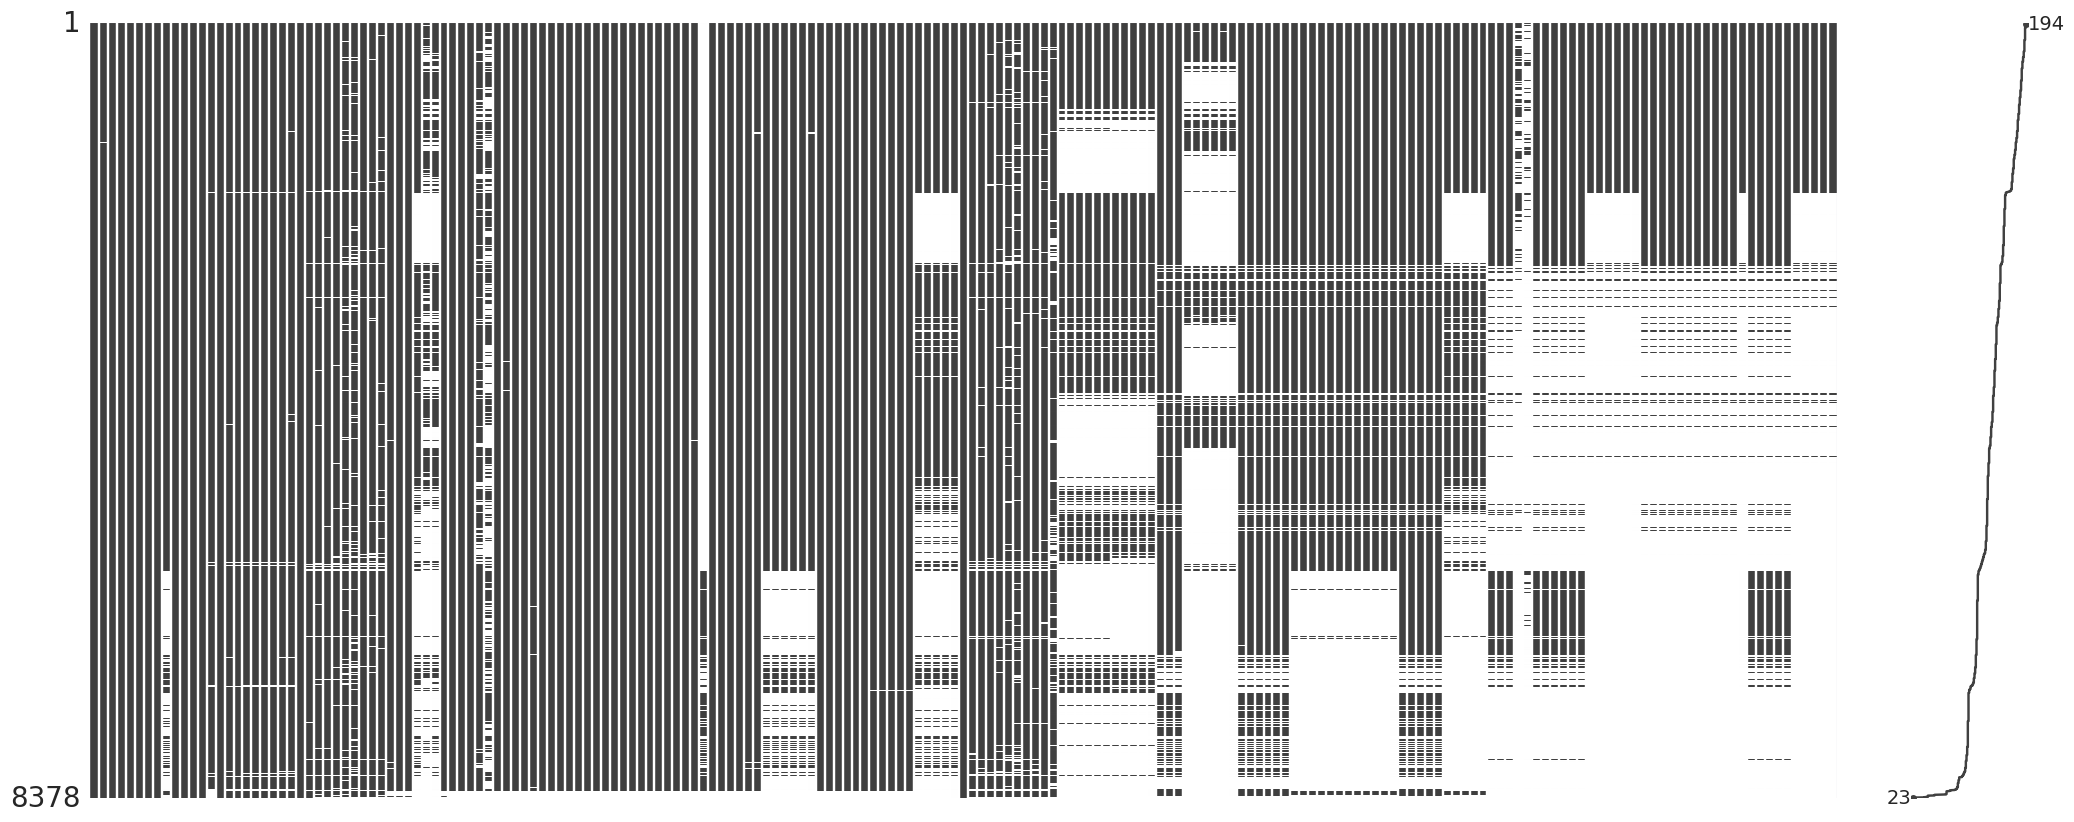

In [27]:
sorted_data = msno.nullity_sort(data_df, sort='descending')
msno.matrix(sorted_data)

# Comments:

As you can see, there is still quite a lot of incomplete data.  We are going to limit what data we use down to what would be available at the beginning of the speed dating session, since our goal is to not actually have to do the speed dating with those who are not likely to be matches.

In [28]:
# note 'career_c' is incomplete and needs to add
# And also 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1' are not filled 
use_features = ['iid', 'gender', 'wave', 'pid', 'match', 'samerace', 'age_o', 'race_o', \
                 'pf_o_att', 'pf_o_sin', 'pf_o_int','pf_o_fun', 'pf_o_amb', 'pf_o_sha',\
                 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'sports',\
                 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',\
                 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',\
                 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1',\
                 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']
Data_df = data_df[use_features]

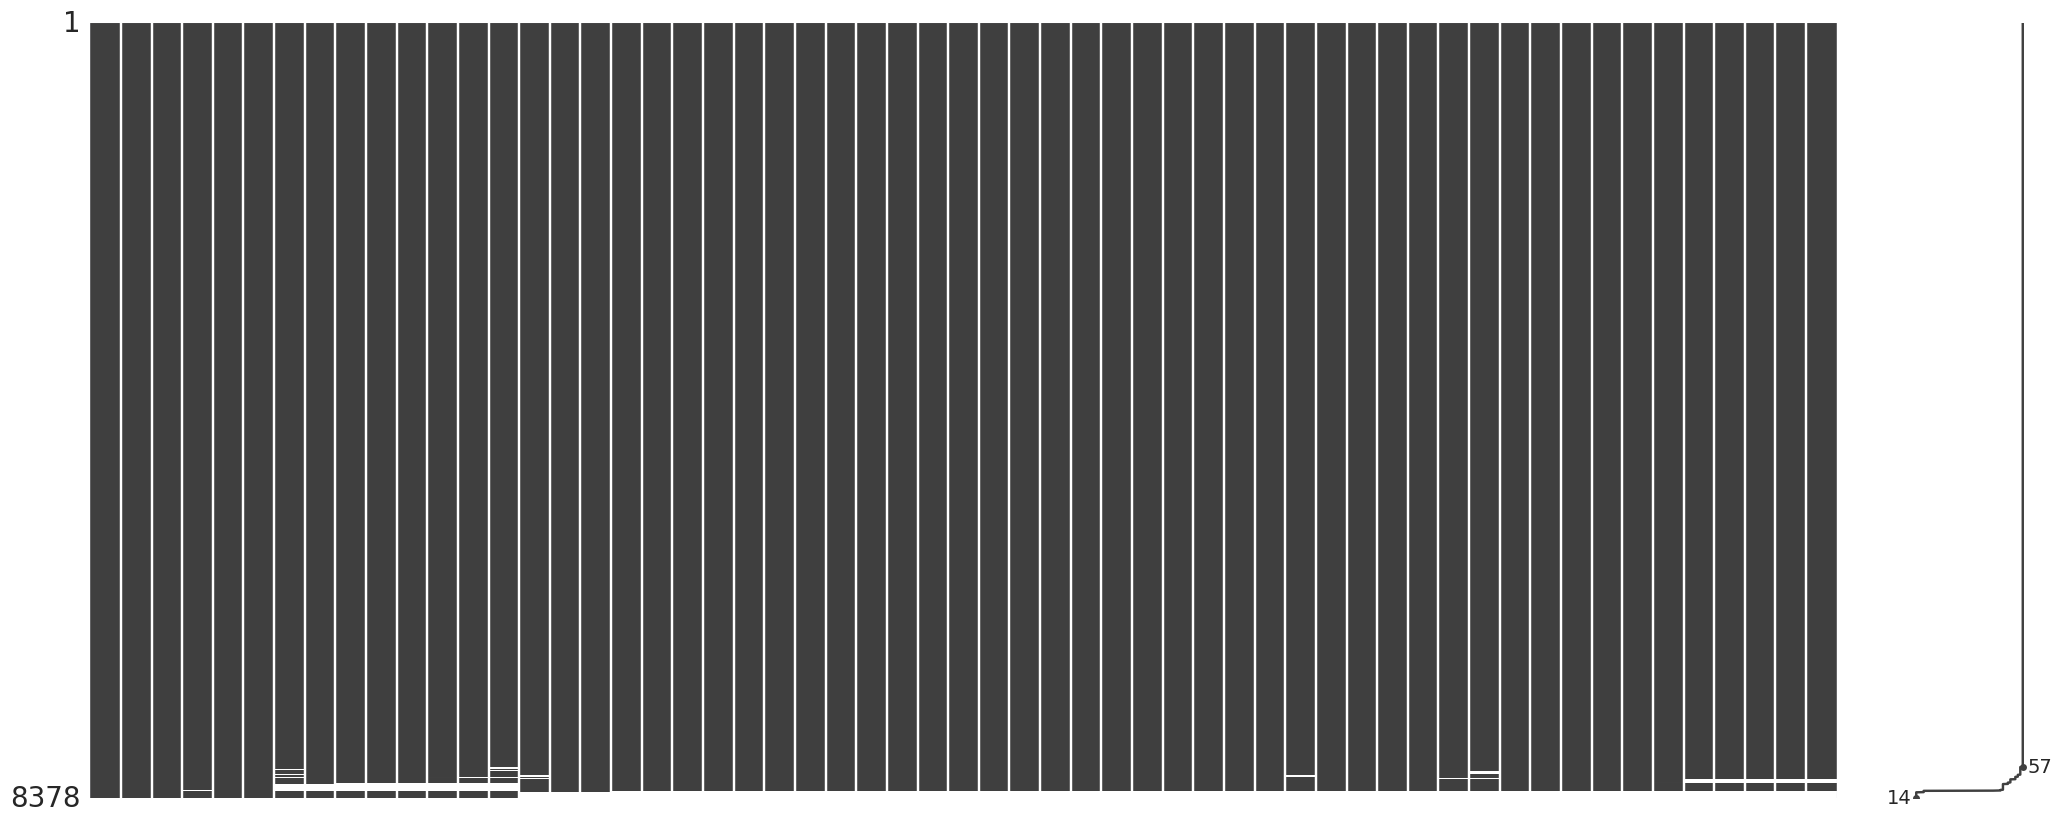

In [29]:
sorted_data = msno.nullity_sort(Data_df, sort='descending')
msno.matrix(sorted_data)

# Comments:

That's a lot better now. It limited the data to what people ranked as important to them at the beginning of the session, as well as some demographic information and how they rated themselves on various factors of attractiveness.

In the following code we make sure that the scales across waves are on the same scales for us to run analysis on.  We also get rid of rows that still contain NaNs - we don't want to date someone who can't fill out a survey all the way, and it would throw off the analysis. 

In [30]:
# we will change the 100 pts measure to 1~10 scale
# First, get all the data where wave 1-5, 10-21 where people use pts measure
pts = Data_df[(Data_df['wave']>9)|(Data_df['wave']<6)]
pts_ind = pts.index
f1 = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
f2 = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
print(Data_df.loc[pts_ind,f1].max())
# however, some scale are written in pts
scale = Data_df[(Data_df['wave']<10)&(Data_df['wave']>5)]
print("However, somehow some entries that are supposed to be scale also use pts\n", scale[f1].max())
# by a closer look, we found that wave 6-9 also uses pts measure on f1 and f2 instead of 1-10 scale
scale_pts1 = scale[np.sum(scale[f1]>10,axis=1)==0]
scale_pts2 = scale[np.sum(scale[f2]>10,axis=1)==0]
print("The only one that is not in pts measure are those with Nan value")
scale_pts1[f1+f2]
# so we will just keep it as it is

attr1_1     100.0
sinc1_1      60.0
intel1_1     50.0
fun1_1       50.0
amb1_1       53.0
shar1_1      30.0
dtype: float64
However, somehow some entries that are supposed to be scale also use pts
 attr1_1     27.78
sinc1_1     23.81
intel1_1    23.81
fun1_1      27.78
amb1_1      20.59
shar1_1     23.81
dtype: float64
The only one that is not in pts measure are those with Nan value


,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1
1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# first get rid off any rows contain Nan value
inds = pd.isnull(Data_df).any(1).nonzero()[0] # row index that contains Nan
print("number of rows contain Nan:", len(inds))
Data_df= Data_df.drop(Data_df.index[inds])
# notice pid is float, so we change it to int
Data_df['pid'] = Data_df['pid'].astype(int)
Data_df['iid'] = Data_df['iid'].astype(int)

mdata_df = Data_df[Data_df['gender']==1]
fdata_df = Data_df[Data_df['gender']==0]
print(mdata_df.shape)
print(fdata_df.shape)
same1 = []
for i in mdata_df.pid.values:
    if i not in fdata_df.iid.values:
        same1.append(i)
print("some guy's partner is not found in fdata:", list(set(same1)))
same2 = []
for i in fdata_df.pid.values:
    if i not in mdata_df.iid.values:
        same2.append(i)
print("some girl's partner is not found in mdata:", list(set(same2)))

# male features in combination
cmfeatures = ['iid', 'pid', 'match', 'samerace', 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out',\
             'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',\
             'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',\
             'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr2_1', 'sinc2_1',\
             'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']
new_mdata = mdata_df[cmfeatures]
# female features in combination
cffeatures = [cmfeatures[0]] + cmfeatures[4:]
new_fdata = fdata_df[cffeatures].drop_duplicates()
new_data = pd.DataFrame.copy(new_mdata)
new_fdata.columns = [i+'_f' for i in cffeatures] # rename the feature name of female

number of rows contain Nan: 336
(4007, 57)
(4035, 57)
some guy's partner is not found in fdata: [416]
some girl's partner is not found in mdata: [413, 414]


# Comments:

Now that the data is cleaned up, we need to pair off participants.  We want to look at which couples went on to a second date, so we pair off each couple from their ID numbers.  Once they have been paired off we can then eliminate all of the collumns that contain an ID number, since those will do nothing except further throw off the model.  

In [32]:
print("building data for pairs...")
df = pd.DataFrame()
for i in new_mdata.index.values:
    m_info = new_mdata.loc[i,:]
    pid = new_mdata.loc[i,'pid'] # this is the (female)partener's ID
    f_ind = new_fdata.iid_f==pid
    if sum(f_ind) !=0: # append only if the pid is found in female iid
        f_info_df = new_fdata[f_ind]
        f_info = f_info_df.loc[f_info_df.index[0],:]
        combined = m_info.append(f_info)
        df = df.append(combined,ignore_index=True)
# now drop features that we do not need for prediction
drop_features = ['iid', 'pid', 'iid_f']
print("Done making data for pairs")
pair_df = df.drop(drop_features,axis=1)
pair_df.head()

building data for pairs...
Done making data for pairs


,age,age_f,amb1_1,amb1_1_f,amb2_1,amb2_1_f,amb3_1,amb3_1_f,art,art_f,...,sports,sports_f,theater,theater_f,tv,tv_f,tvsports,tvsports_f,yoga,yoga_f
0,27.0,21.0,0.0,15.0,25.0,5.0,5.0,7.0,5.0,1.0,...,8.0,9.0,4.0,1.0,2.0,9.0,7.0,2.0,1.0,1.0
1,27.0,24.0,0.0,0.0,25.0,0.0,5.0,3.0,5.0,6.0,...,8.0,3.0,4.0,9.0,2.0,1.0,7.0,2.0,1.0,1.0
2,27.0,25.0,0.0,10.0,25.0,0.0,5.0,8.0,5.0,5.0,...,8.0,3.0,4.0,7.0,2.0,8.0,7.0,8.0,1.0,7.0
3,27.0,23.0,0.0,10.0,25.0,5.0,5.0,8.0,5.0,7.0,...,8.0,1.0,4.0,9.0,2.0,7.0,7.0,1.0,1.0,8.0
4,27.0,21.0,0.0,10.0,25.0,5.0,5.0,8.0,5.0,8.0,...,8.0,7.0,4.0,6.0,2.0,8.0,7.0,4.0,1.0,3.0


In [33]:
pair_train = pair_df.drop('match',axis=1)
pair_label = pair_df['match']
print("total training data size:", pair_df.shape)
pd.Series.value_counts(pair_label)

total training data size: (3999, 88)


0.0    3345
1.0     654
Name: match, dtype: int64

# Comments:

Training and testing split!!  We need this for some of our models, so now is a good time to get it done.  

In [34]:
# create train and test data
train_data, test_data = train_test_split(pair_df, test_size=0.3, random_state=42, stratify=pair_df['match'])
predictors = [x for x in pair_df.columns if x not in ['match']]
print("train shape:", train_data.shape)
print("test shape:", test_data.shape)
print(train_data.head())
print(predictors)
print(len(predictors))

train shape: (2799, 88)
test shape: (1200, 88)
       age  age_f  amb1_1  amb1_1_f  amb2_1  amb2_1_f  amb3_1  amb3_1_f  art  \
2229  23.0   29.0     5.0       3.0    15.0       2.0     9.0       5.0  8.0   
2101  27.0   22.0    12.0       8.0     5.0      10.0     9.0       8.0  7.0   
676   25.0   22.0     0.0       5.0    10.0      10.0     6.0       4.0  5.0   
717   21.0   25.0     5.0       2.0    10.0       2.0     6.0       8.0  7.0   
3304  23.0   26.0     5.0      10.0    20.0      10.0     5.0       7.0  7.0   

      art_f   ...    sports  sports_f  theater  theater_f   tv  tv_f  \
2229    7.0   ...       7.0       8.0      6.0        8.0  5.0   7.0   
2101    9.0   ...       9.0       8.0      6.0        9.0  5.0   8.0   
676     7.0   ...       9.0       2.0      6.0        5.0  6.0   7.0   
717     5.0   ...       7.0       4.0      5.0       10.0  1.0   7.0   
3304    9.0   ...       3.0       9.0      7.0        7.0  2.0   4.0   

      tvsports  tvsports_f  yoga  yoga_

# Comments:

Knowing if they matched kind of takes away the point of the predictions, so for models that need their results and variables split up we get the 'match' collumn seperate from the rest of the data.

In [35]:
X = train_data[predictors]
print(X.shape)
Y = train_data['match']
print(Y.shape)

(2799, 87)
(2799,)


# Comments:

Before anything else, let's see if we can eliminate many more variables and still have a fairly complete model.  Since there is currently 87 predictors that we are including, cutting back even more eliminates the need for extra data collection and could significantly speed up our models.

In [36]:
x = [5, 10, 15, 20, 25, 30, 35, 40]
for i in x:
    pca = PCA(n_components=i)
    pca.fit(train_data)
    print("Number of components: ", i)
    #print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))

Number of components:  5
0.528025893191
Number of components:  10
0.688587948728
Number of components:  15
0.786327341183
Number of components:  20
0.850593092336
Number of components:  25
0.891180674275
Number of components:  30
0.919399049883
Number of components:  35
0.939320520115
Number of components:  40
0.953793161321


# Comments:

We can apparently still get 95% of the variance shown through only fourty of the 87 predictors, which seems like a reasonable trade off.  Let's see what the data looks like now.

In [37]:
pca = PCA(n_components=40)
pca.fit(train_data)
# apply the feature vector to the data set
pca_data_set = pd.DataFrame(pca.transform(train_data))
pca_test = pd.DataFrame(pca.transform(test_data))
print("Dimensionally-reduced data set (tail):")
display(pca_data_set.tail())

Dimensionally-reduced data set (tail):


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2794,-10.165908,-35.902533,-3.282119,-2.003166,-9.722441,-11.972099,-10.954696,-7.061653,-22.489129,3.399347,...,-1.456038,1.337410,-1.272620,-2.411424,2.306186,2.881208,0.723077,-1.023989,2.178461,-1.328588
2795,-84.560796,-33.378809,-10.331178,-13.977561,-9.190811,10.325225,17.873323,1.255886,-2.255893,0.795458,...,4.208518,-0.632342,-1.333248,3.663441,-1.530106,1.932801,-6.851909,1.290214,3.601440,-0.749663
2796,-23.077556,12.284940,-2.071995,-10.627886,-6.426881,0.440160,-2.495656,16.312942,-14.619676,10.762254,...,-6.087219,0.714790,-4.230915,3.372063,-1.208977,-1.557472,0.572733,-3.494413,0.507148,7.109121
2797,10.879324,-5.768559,-11.835596,-9.807587,-1.851333,11.152325,3.339826,-1.048941,0.352189,-0.969697,...,-1.761963,-0.797119,3.404948,0.379145,2.606593,-1.274543,0.009211,1.997410,-0.417327,1.188272
2798,18.761564,4.031266,2.404184,2.669170,-2.399715,-2.681947,3.030343,-2.434915,1.381772,0.248729,...,-0.924675,3.919510,0.950966,2.760678,1.335677,-0.178532,0.459146,-0.872266,-1.611423,2.204750


['age' 'fun1_1_f' 'amb3_1_f' 'sinc1_1' 'shar2_1_f' 'clubbing_f'
 'field_cd_f' 'shar1_1' 'concerts_f' 'shar1_1_f']

In [38]:
most_imp = ['age', 'fun1_1_f', 'amb3_1_f', 'sinc1_1', 'shar2_1_f', 'clubbing_f', 'field_cd_f', 'shar1_1', 'concerts_f', 'shar1_1_f']
trimmed = X[most_imp]
train_imp = ['match', 'age', 'fun1_1_f', 'amb3_1_f', 'sinc1_1', 'shar2_1_f', 'clubbing_f', 'field_cd_f', 'shar1_1', 'concerts_f', 'shar1_1_f']
train_trim = train_data[train_imp]
train_true = train_data[predictors]
test_true = test_data[predictors]
test_trim = test_data[most_imp]
y_test = test_data['match']

# Comments:

For the sake of visualization, we've selected a few features to do a quick visual check for any obvious clustering.  Unfortunately, there is a lot of overlap between those dates that paired off and those that didn't, so we're probably going to need something other than clustering algorithms. For the sake of completeness though, let's try at least one.

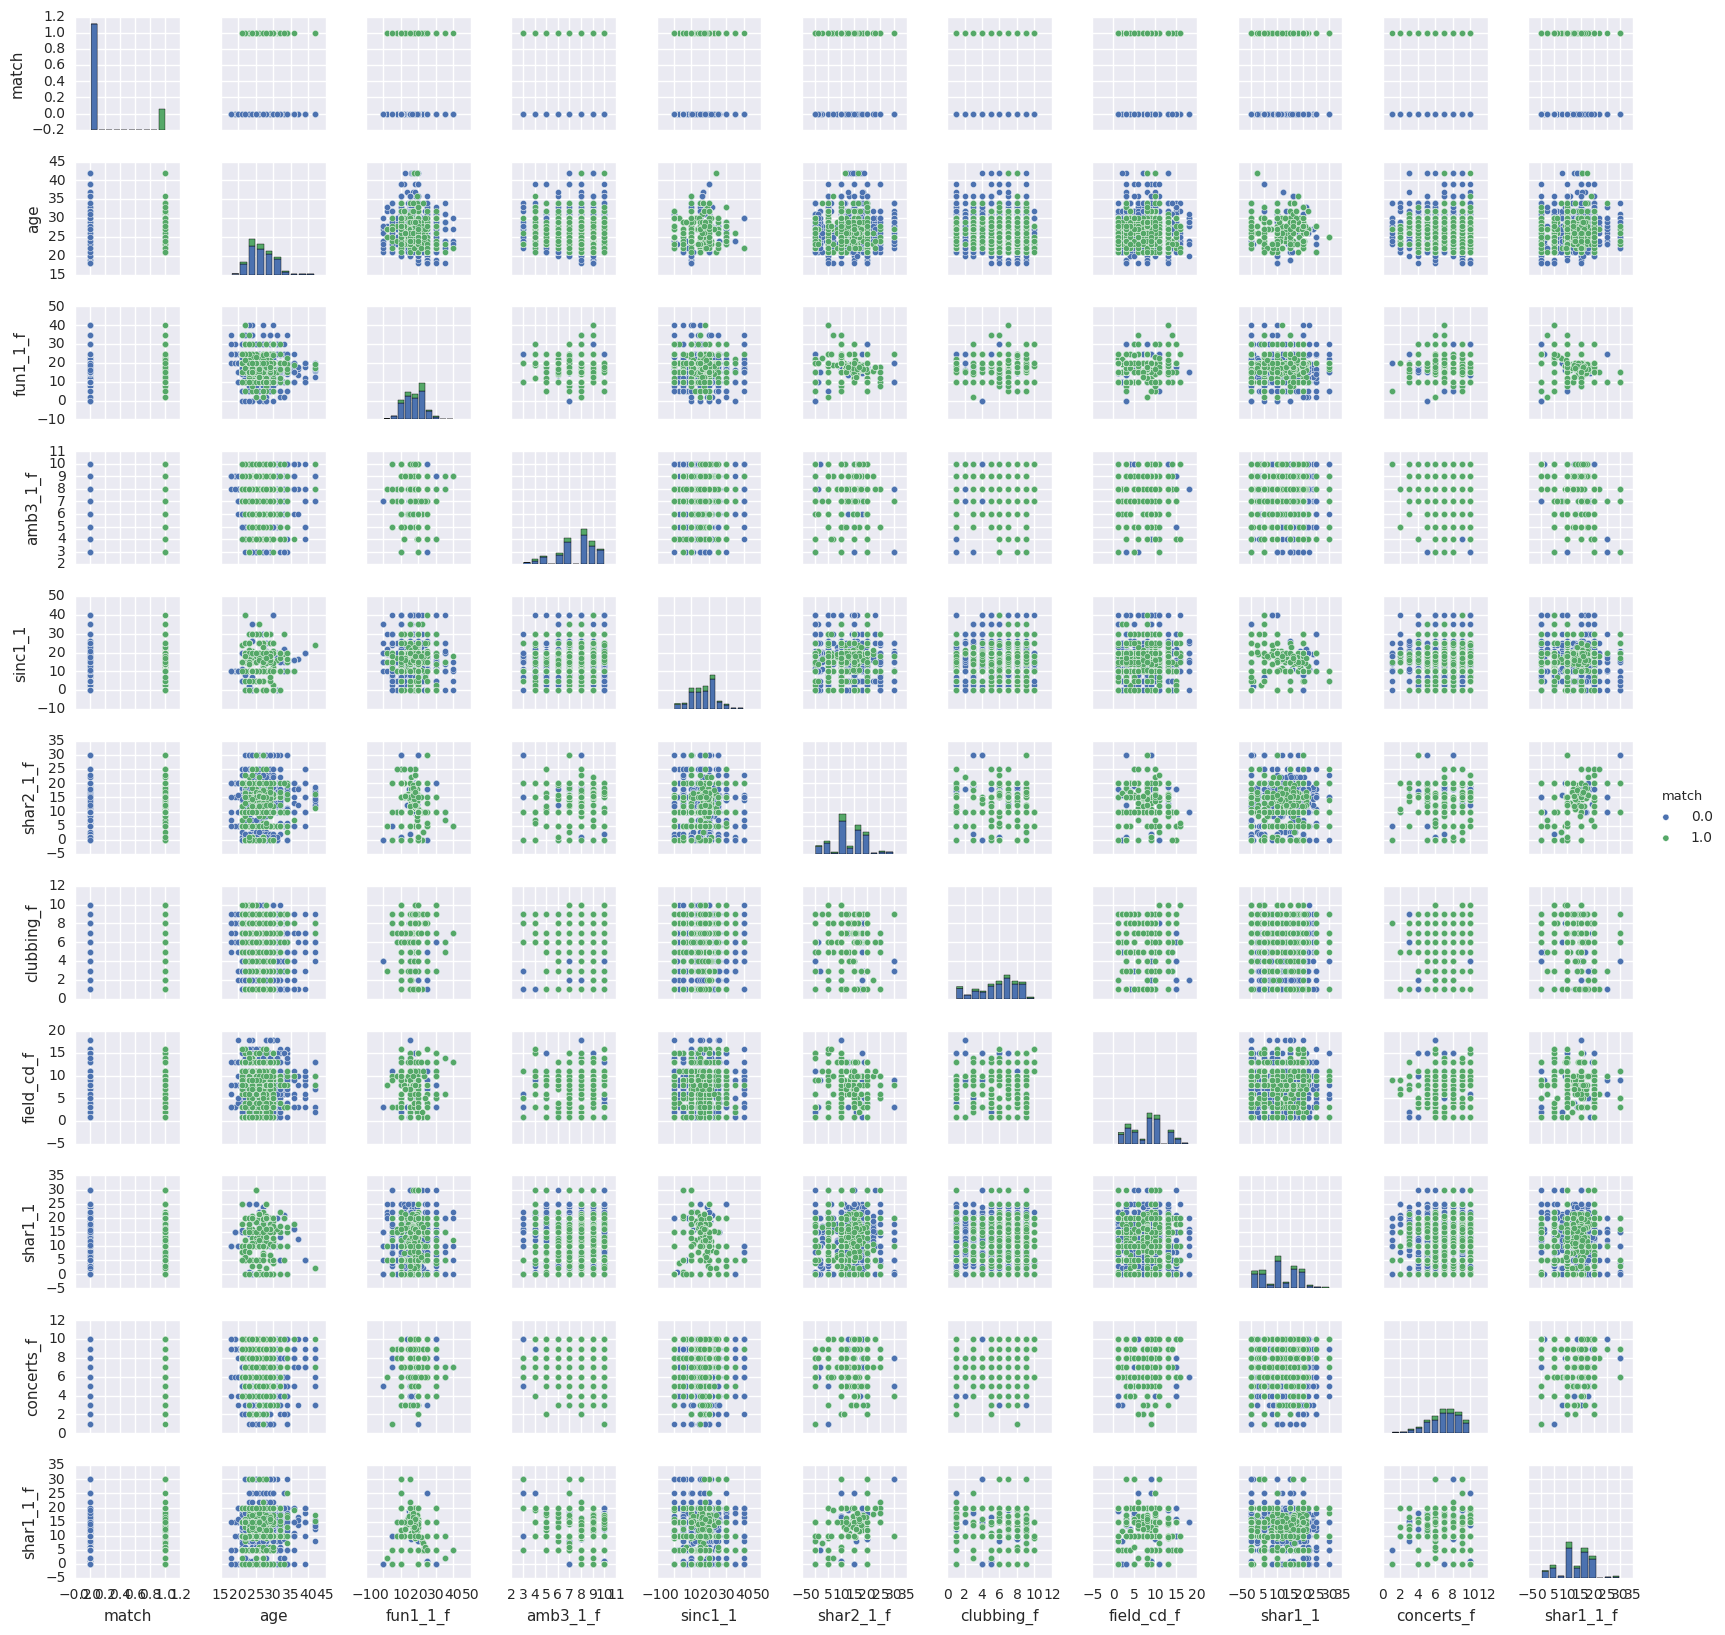

In [39]:
import seaborn as sns; sns.set()
sns.pairplot(train_trim, hue='match', size=1.5);

In [40]:
kmeans = KMeans(n_clusters=2) #We KNOW it's only two clusters, either you got a date or you didn't
kmeans.fit(pca_data_set)
y_kmeans = kmeans.predict(pca_data_set)

             precision    recall  f1-score   support

        0.0       0.82      0.32      0.46      2341
        1.0       0.16      0.64      0.25       458

avg / total       0.71      0.37      0.43      2799



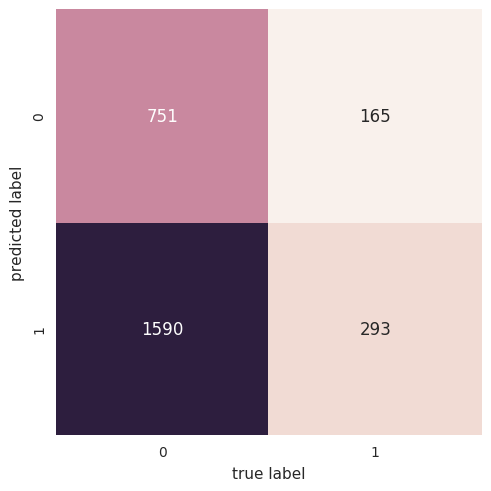

In [41]:
mat = confusion_matrix(Y, y_kmeans)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(Y, y_kmeans))

# Comments:

Well, 75% precision is better than a coin flip.  Let's see if we pulled out too many factors from when we did the PCA anlysis.

In [42]:
kmeans = KMeans(n_clusters=2) #We KNOW it's only two clusters, either you got a date or you didn't
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

             precision    recall  f1-score   support

        0.0       0.84      0.68      0.75      2341
        1.0       0.18      0.36      0.24       458

avg / total       0.74      0.63      0.67      2799



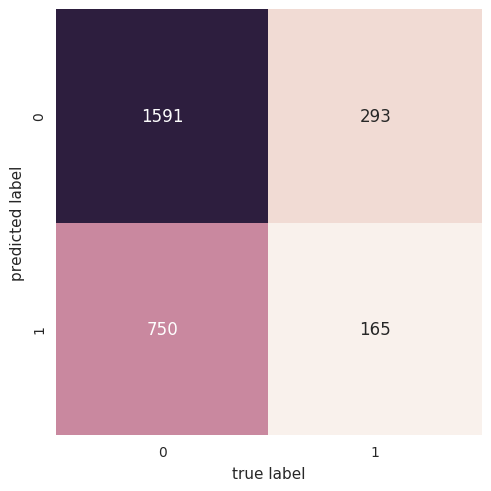

In [43]:
mat = confusion_matrix(Y, y_kmeans)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(metrics.classification_report(Y, y_kmeans))

# Comments:

Precision is now down to 71%.  So, absolutely no clumping, and quite frankly a very optimistic algorithm.  

As you can see from the elements selected in the pairplot a few cells up, there is no clear clustering that we can distinguish, as most individual variables have a lot of overlap, so there is no clear line in between those couples that matched and those that did not.  

Therefore, let's check on something that doesn't use clustering.

Random forest!!  Just because we're using our trimmed data first, but then we're going to check using the complete data set since decision trees automatically choose the most influential factor at each node.

             precision    recall  f1-score   support

        0.0       1.00      0.84      0.91      1195
        1.0       0.02      0.80      0.04         5

avg / total       0.99      0.84      0.91      1200



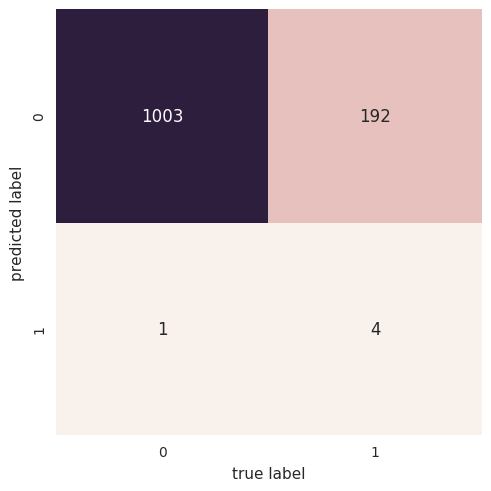

In [44]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(pca_data_set, Y)
ypred = model.predict(pca_test)

print(metrics.classification_report(ypred, y_test))

mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

             precision    recall  f1-score   support

        0.0       1.00      0.84      0.92      1190
        1.0       0.05      1.00      0.10        10

avg / total       0.99      0.84      0.91      1200



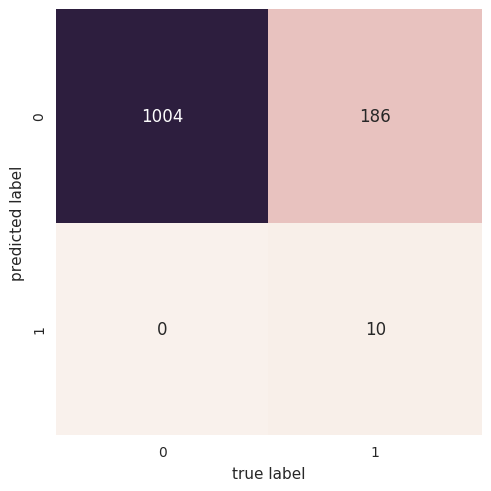

In [45]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(train_true, Y)
ypred = model.predict(test_true)

print(metrics.classification_report(ypred, y_test))

mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# Comments:

We obtain an overall precision of 99% in both, though the recall for the pairs was 100% using the entire data set.  Granted, with the initial goal of predicting what couples will match, we have terrible precision.  We correctly predicted the couples that won't match, and had a very minimal amount of false positives.  

Long story short, humans are complicated but can still be predicted - most of the time.  And if you assume that you'll never get a date your overall precision will be pretty good.